
# Classification and KNN with Churn data - Modelling

_By: Lujain Felemban_


---


In [1]:
#import the relevent libraries for data reading, cleaning, and analysis
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.5)

plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Modelling - Following the notebook before

In [2]:
#import cleaned data
df = pd.read_csv('CleanChurn.csv', )

In [3]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.CustomerId = df.CustomerId.astype(str)
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15701354,Boni,699,France,0.0,39,1,0.00,2,0,0,0.00,0
1,15767821,Bearce,528,France,1.0,31,6,102016.72,2,0,0,0.00,0
2,15788218,Henderson,549,Spain,0.0,24,9,0.00,2,1,1,0.00,0
3,15625047,Yen,846,France,0.0,38,5,0.00,1,1,1,0.00,0
4,15656300,Lucciano,411,France,1.0,29,0,59697.17,2,1,1,53483.21,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
CustomerId         8128 non-null object
Surname            8128 non-null object
CreditScore        8128 non-null int64
Geography          8128 non-null object
Gender             8128 non-null float64
Age                8128 non-null int64
Tenure             8128 non-null int64
Balance            8128 non-null float64
NumOfProducts      8128 non-null int64
HasCrCard          8128 non-null int64
IsActiveMember     8128 non-null int64
EstimatedSalary    8128 non-null float64
Exited             8128 non-null int64
dtypes: float64(3), int64(7), object(3)
memory usage: 825.6+ KB


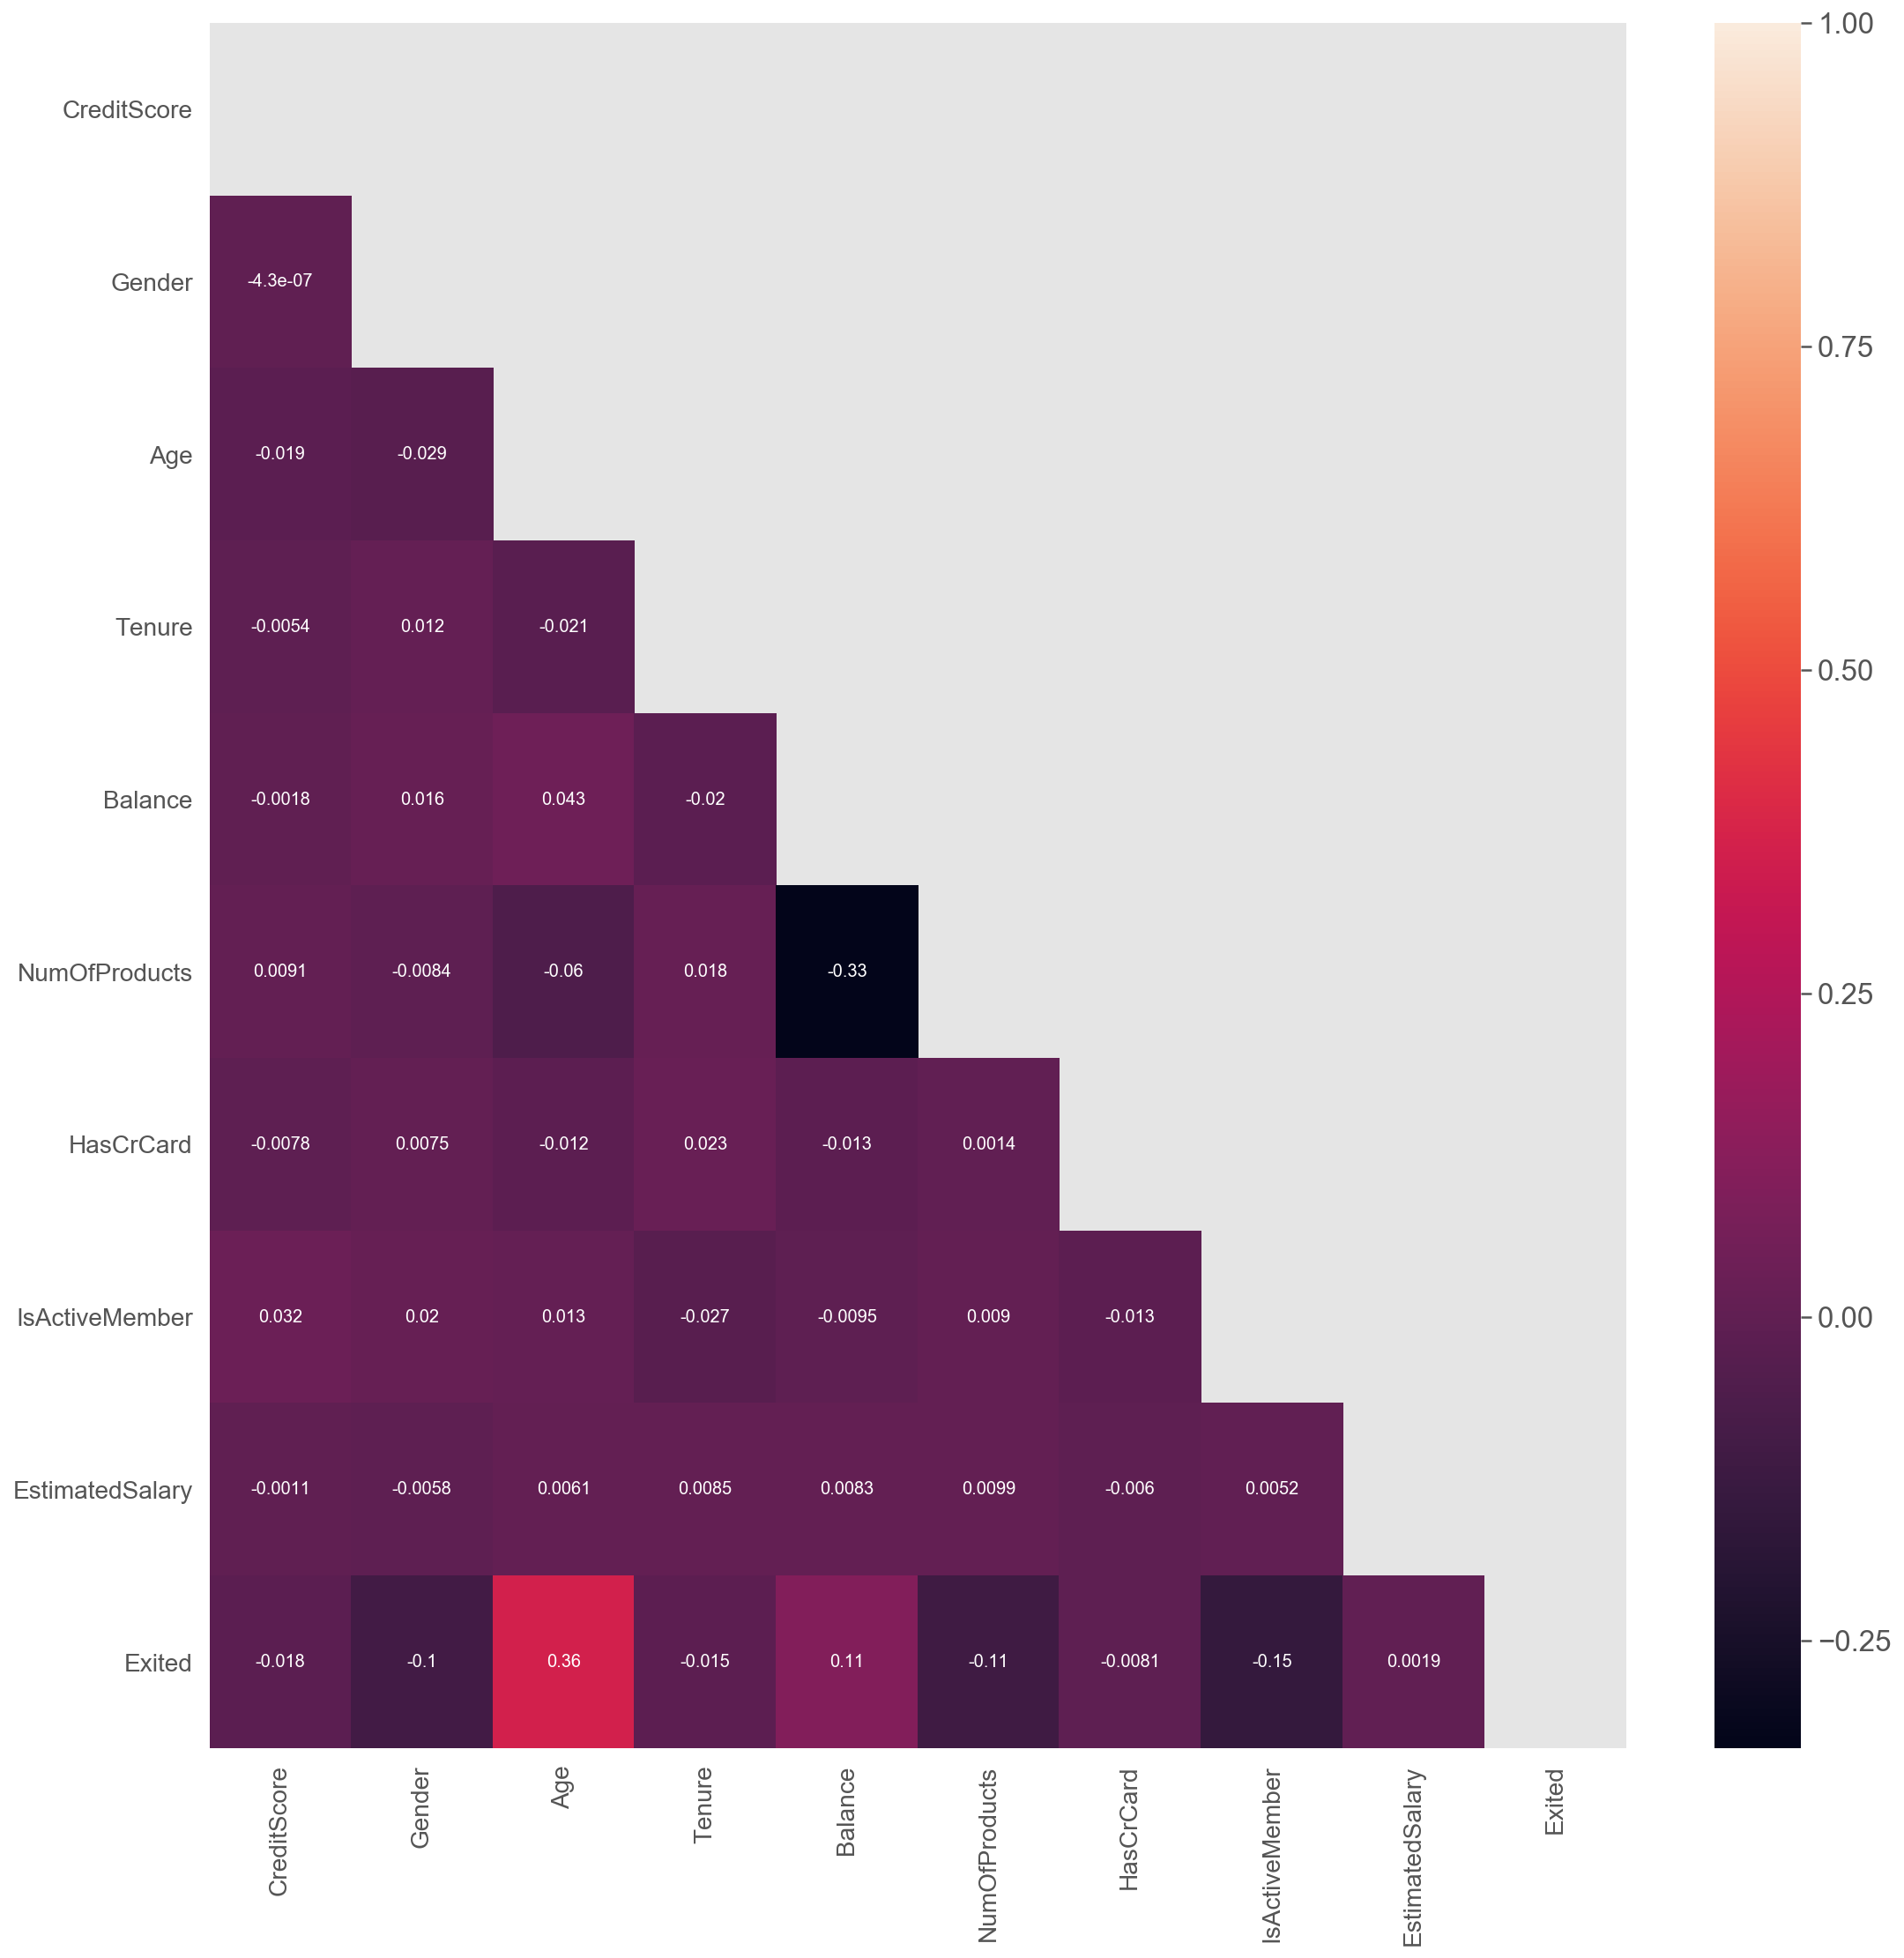

In [5]:
corr = df.corr()

fig, ax = plt.subplots(figsize=(18,18))

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corr, mask=mask, ax=ax, annot=True)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

plt.show()

//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


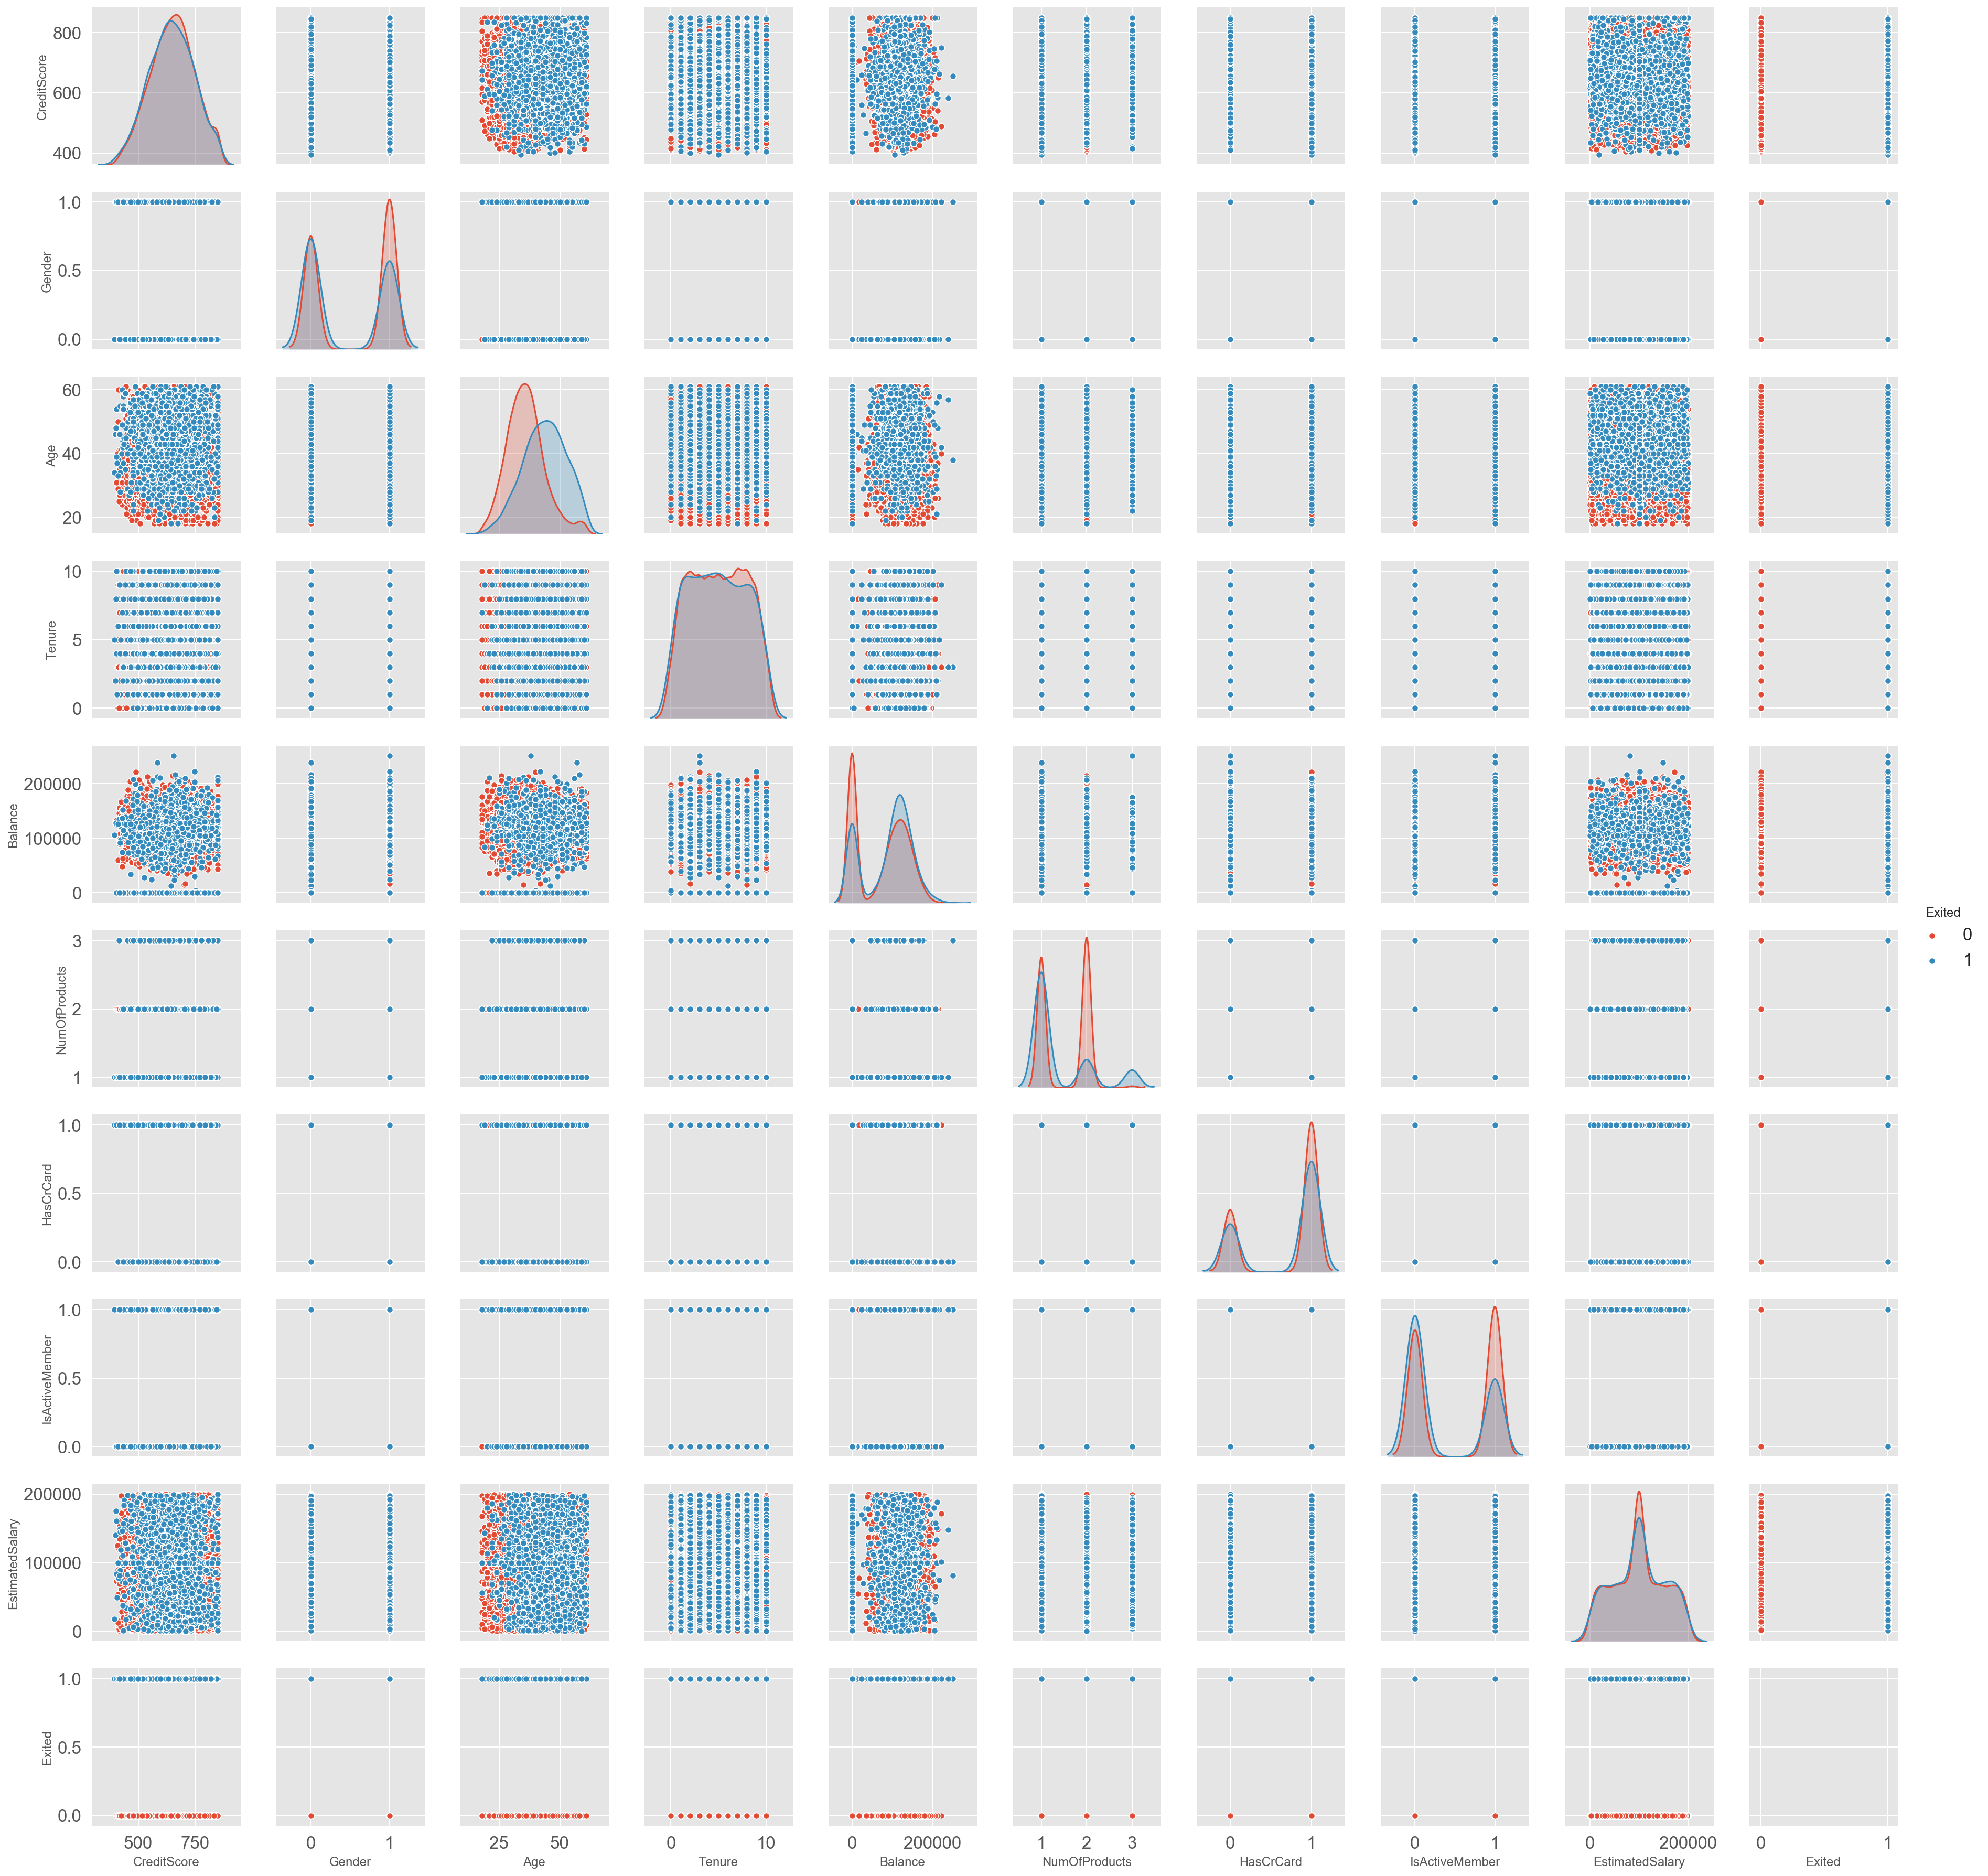

In [6]:
# plot pairplot for all features
sns.pairplot(df.select_dtypes(np.number), hue='Exited');
# note we didn't dummify surename because racism and country because too much

As suspected, there is no clear correlation between the Exited and any of the variables. Therefore I will choose my X to be all features. I do know that KNN is very sensitive to bad feature and given mor etime, I would try a combination of features.

In [7]:
y = df.loc[df.isna().sum(axis=1) == 0 , "Exited"]
X = df.drop("Exited", axis=1)
X = pd.get_dummies(X)

### What is the baseline accuracy?

In [8]:
y.count()

8128

In [9]:
y.value_counts()

0    6508
1    1620
Name: Exited, dtype: int64

In [10]:
# calculate the baseline accuracy:
y.value_counts(normalize=True)

0    0.800689
1    0.199311
Name: Exited, dtype: float64

In [11]:
# baseline is ~80% (proportion of majority class: Exited 0)

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score, recall_score, make_scorer
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV, train_test_split

In [18]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y)

In [20]:
len(X_train) , len(X_test)

(6096, 2032)

In [21]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

### 1. KNN model

In [22]:
knn = KNeighborsClassifier(6, n_jobs=-1)
knn.fit(X_train_ss, y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=6, p=2,
                     weights='uniform')

In [23]:
knn.score(X_test_ss, y_test)

0.8006889763779528

In [24]:
confusion_matrix(y_test, knn.predict(X_test_ss))

array([[1615,   12],
       [ 393,   12]])

### 2. Logistic Regression Model

In [25]:
from sklearn.linear_model import LogisticRegressionCV

In [26]:
model = LogisticRegressionCV().fit(X_train_ss, y_train)

model.score(X_test_ss, y_test)

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.7913385826771654

accuracy is lower than baseline's

In [27]:
confusion_matrix(y_test, model.predict(X_test_ss))

array([[1598,   29],
       [ 395,   10]])

#### Let's try and make our target classes balanced and see if the score would improve

In [29]:
from imblearn.over_sampling import SMOTE, ADASYN

In [30]:
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_ss, y_train)

In [31]:

knn = KNeighborsClassifier()

parameters = {'n_neighbors':[3,5,7]}

#Fit the model
model = GridSearchCV(knn, param_grid=parameters)
model.fit(X_train_smote, y_train_smote)

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None, param_grid={'n_neighbors': [3, 5, 7]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [32]:
model.score(X_train_smote, y_train_smote)

0.5424093423478795

In [33]:
model.score(X_test_ss, y_test)

0.22539370078740156

In [34]:
confusion_matrix(y_test, model.predict(X_test_ss))

array([[  83, 1544],
       [  30,  375]])

## Conclusion 


Overall, the churn dataset did not require much cleaning. Even without a dictionary, all the varibles were clear. However, the dataset does not have a lot of variables overall and barely any with clear correlation which the target variable, which made the process of fitting a good model using knn very hard. Given more time, I would try the following:

- Try feature engineering such as Emplyment status from Salary ( with those less than a certain logical number to be not full-time employed)
- Spend more time trying different combinations of X features to feed into knn
- Increase the number of K values to gridsearch and plot the error with each K to find the optimal one
- try other classification models, such as decision trees or support vector and enseble methods as well.
- Better impute the missing data (gender and estimated salary), perhaps with modelling
